# JMH Benchmark Parser & Plotting Toolkit

This notebook provides:
1. A parser to extract datasets from JMH-style table output into typed arrays grouped by benchmark name.
2. Plotting helpers to compare **2, 3, 4, or 5** datasets on one chart.
3. A regression plotter that overlays a polynomial fit of configurable degree.

**Conventions**
- Parsed structure per benchmark: `List[Tuple[int, Tuple[float, float]]]` → `(size, (avg, error))`.
- `size` is taken from the filename part like `... 2_456chars.json ...` → `456`.
- Plot functions accept optional `output_folder` and `fmt` (`"svg"` or `"eps"`). If provided, figures are saved there.


In [60]:

# Imports (matplotlib only; seaborn intentionally not used)
from __future__ import annotations
import re
from typing import Dict, List, Tuple, Sequence, Iterable, Optional
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def _ensure_save(fig, filename: Optional[str|Path], fmt: str = "svg", output_folder: Optional[str|Path] = None):
    """Save `fig` if `output_folder` is provided. Returns output path or None."""
    if output_folder is None:
        return None
    fmt = (fmt or "svg").lower()
    if fmt not in {"svg", "eps"}:
        raise ValueError(f"Unsupported format: {fmt!r}. Use 'svg' or 'eps'.")
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    filename = Path(filename) if filename is not None else Path("figure")
    outpath = output_folder / (filename.stem + f".{fmt}")
    fig.savefig(outpath, format=fmt, bbox_inches="tight", dpi=300)
    return outpath


In [61]:

def parse_jmh_table(raw_text: str) -> Dict[str, List[Tuple[int, Tuple[float, float]]]]:
    """Parse JMH-like '[info] Benchmark ...' table lines into datasets.

    Returns a dict mapping benchmark name → list of (size, (avg, error)).
    The list is sorted by size. Lines that don't match the expected table pattern are ignored.

    Expected columns pattern (loose, handles variable spacing):
      [info] <BenchmarkName> <file> <mode> <cnt> <score> ± <error> <units>

    Size extraction rule:
      Take the integer *immediately before* the 'chars' token in the filename.
      E.g., '102_23677chars.json' → 23677 ; '2_456chars.json' → 456.
    """
    datasets: Dict[str, List[Tuple[int, Tuple[float, float]]]] = {}

    # Regex for the table line
    line_re = re.compile(
        r"^\[info\]\s+"                               # prefix
        r"(?P<bench>\S+)\s+"                           # benchmark name
        r"(?P<file>\S+)\s+"                            # filename token
        r"(?P<mode>\S+)\s+"                            # mode (e.g., avgt)
        r"(?P<cnt>\d+)\s+"                             # count
        r"(?P<score>\d+(?:\.\d+)?)\s+"               # score (avg)
        r"±\s+"
        r"(?P<error>\d+(?:\.\d+)?)\s+"               # error
        r"(?P<units>\S+)\s*$"                          # units
    )

    # Extract the size found right before 'chars' inside the file token
    size_re = re.compile(r"_(?P<size>\d+)chars\b", re.IGNORECASE)

    for line in raw_text.splitlines():
        m = line_re.match(line)
        if not m:
            continue

        bench = m.group("bench")
        filetok = m.group("file")
        score = float(m.group("score"))
        error = float(m.group("error"))

        sm = size_re.search(filetok)
        if not sm:
            # If pattern fails, try to fallback to the last integer run in the token
            # (keeps the parser resilient for edge cases).
            m2 = re.search(r"(\d+)(?=\D*$)", filetok)
            if not m2:
                continue
            size = int(m2.group(1))
        else:
            size = int(sm.group("size"))

        datasets.setdefault(bench, []).append((size, (score, error)))

    # Sort each dataset by size
    for k in list(datasets.keys()):
        datasets[k].sort(key=lambda t: t[0])

    return datasets


In [62]:

from matplotlib import colors


def _prep_xy(series: List[Tuple[int, Tuple[float, float]]]):
    xs = [s for s, _ in series]
    ys = [v[0] for _, v in series]
    yerr = [v[1] for _, v in series]
    return np.array(xs), np.array(ys), np.array(yerr)

# A list of easily distinguishable colors for colorblind-safe plots
_COLOR_CYCLE = [
    "#377eb8",  # blue
    "#ff7f00",  # orange
    "#ff50ad",  # pink
    "#e41a1c",  # red
    "#dede00",  # yellow
]

def _plot_many(datasets: Sequence[Tuple[str, List[Tuple[int, Tuple[float, float]]]]], 
               pretty_data_labels: Optional[Dict[str, str]] = None,
               title: Optional[str] = None,
               output_folder: Optional[str|Path] = None,
               fmt: str = "svg",
               filename: Optional[str|Path] = None):
    n = len(datasets)
    if n < 2 or n > 5:
        raise ValueError("_plot_many expects between 2 and 5 datasets.")

    fig, ax = plt.subplots(figsize=(7, 5))
    for label, series in datasets:
        xs, ys, yerr = _prep_xy(series)
        if pretty_data_labels and label in pretty_data_labels:
            label = pretty_data_labels[label]
        ax.errorbar(xs, ys, yerr=yerr, marker='o', linestyle='', label=label, 
                    color=_COLOR_CYCLE[len(ax.lines) % len(_COLOR_CYCLE)],
                    capsize=3)
    ax.set_xlabel("Input size (chars)")
    ax.set_ylabel("Average time (us/op)")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    if title:
        ax.set_title(title)
    ax.legend()

    saved = _ensure_save(fig, filename or (title or f"compare_{n}_datasets"), fmt, output_folder)
    plt.show()
    return saved

def plot2(d1: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          d2: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          pretty_data_labels: Optional[Dict[str, str]] = None,
          title: Optional[str] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          filename: Optional[str|Path] = None):
    """Plot 2 datasets on the same axes."""
    return _plot_many([d1, d2], pretty_data_labels=pretty_data_labels, title=title, output_folder=output_folder, fmt=fmt, filename=filename)

def plot3(d1, d2, d3, title: Optional[str] = None,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          filename: Optional[str|Path] = None):
    """Plot 3 datasets on the same axes."""
    return _plot_many([d1, d2, d3], pretty_data_labels=pretty_data_labels, title=title, output_folder=output_folder, fmt=fmt, filename=filename)

def plot4(d1, d2, d3, d4, title: Optional[str] = None,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          filename: Optional[str|Path] = None):
    """Plot 4 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4], pretty_data_labels=pretty_data_labels, title=title, output_folder=output_folder, fmt=fmt, filename=filename)

def plot5(d1, d2, d3, d4, d5, title: Optional[str] = None,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          filename: Optional[str|Path] = None):
    """Plot 5 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4, d5], pretty_data_labels=pretty_data_labels, title=title, output_folder=output_folder, fmt=fmt, filename=filename)


In [63]:

def plot_with_regression(dataset: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
                         degree: int = 1,
                         title: Optional[str] = None,
                         output_folder: Optional[str|Path] = None,
                         fmt: str = "svg",
                         filename: Optional[str|Path] = None):
    """Plot a dataset with error bars and overlay a polynomial regression of given degree.

    Parameters
    ----------
    dataset : (name, series) where series is List[(size, (avg, error))].
    degree : polynomial degree (>= 0).
    title : optional str for the plot title.
    output_folder : optional path to save the plot.
    fmt : 'svg' or 'eps' (default: 'svg').
    filename : optional filename stem for saving.
    """
    if degree < 0:
        raise ValueError("degree must be >= 0")

    label, series = dataset
    xs, ys, yerr = _prep_xy(series)

    # Fit polynomial
    coeffs = np.polyfit(xs, ys, deg=degree)
    poly = np.poly1d(coeffs)

    # Smooth line over the observed range
    xfit = np.linspace(xs.min(), xs.max(), 500)
    yfit = poly(xfit)

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.errorbar(xs, ys, yerr=yerr, marker='o', linestyle='--', label=f"{label} (data)")
    ax.plot(xfit, yfit, label=f"Poly deg {degree}")
    ax.set_xlabel("Input size (chars)")
    ax.set_ylabel("Average time (us/op)")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    ax.legend()
    if title:
        ax.set_title(title)

    saved = _ensure_save(fig, filename or (title or f"regression_deg{degree}_{label}"), fmt, output_folder)
    plt.show()
    return saved



### Usage
```python
raw = """<paste your JMH output here>"""
data = parse_jmh_table(raw)

# Example: build tuples for plotting
bench1 = "JsonLexerBenchmark.lex_ZipperMem"
bench2 = "JsonLexerBenchmark.separability_pred"
d1 = (bench1, data[bench1])
d2 = (bench2, data[bench2])

# Compare two datasets
plot2(d1, d2, title="Lex vs Separability", output_folder="plots", fmt="svg")

# Regression for one dataset
plot_with_regression(d2, degree=1, title="Separability: Linear Fit", output_folder="plots", fmt="svg")
```


# JSON Lexer Benchmark Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


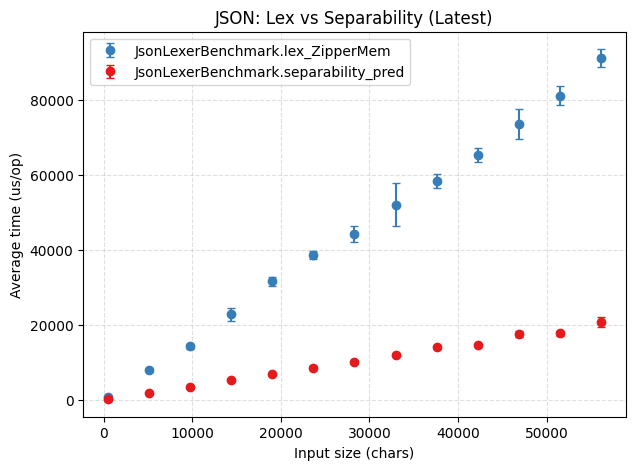

In [64]:
latest_folder = Path("./latest")
json_lexer_file = None
for entry in os.listdir(latest_folder):
    if 'json_lexer' in entry.lower():
        json_lexer_file = latest_folder / entry
        break

bench1 = "JsonLexerBenchmark.lex_ZipperMem"
bench2 = "JsonLexerBenchmark.separability_pred"
    
assert json_lexer_file is not None, "Could not find JSON lexer benchmark file in 'latest' folder."
with open(json_lexer_file, "r") as f:
    raw2 = f.read()
data2 = parse_jmh_table(raw2)
if bench1 in data2 and bench2 in data2:
    d1_new = (bench1, data2[bench1])
    d2_new = (bench2, data2[bench2])
    plot2(d1_new, d2_new, title="JSON: Lex vs Separability (Latest)", output_folder="plots", fmt="eps")
else:
    print(f"Benchmarks {bench1} or {bench2} not found in the latest data.")

# JSON Ordering Benchmark Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


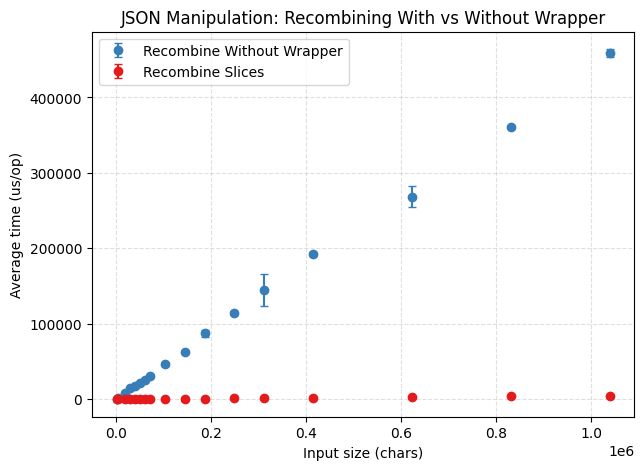

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


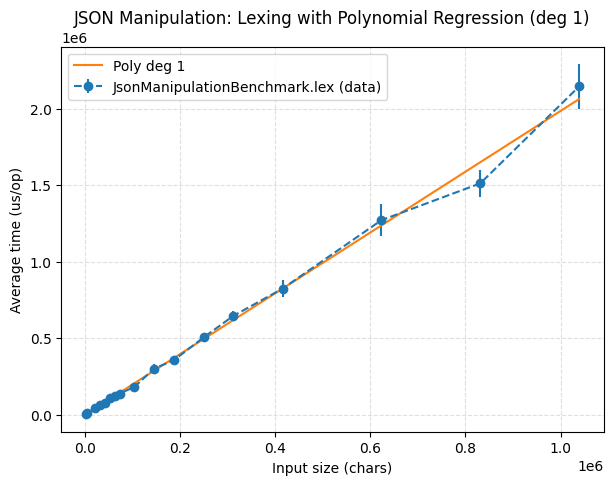

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


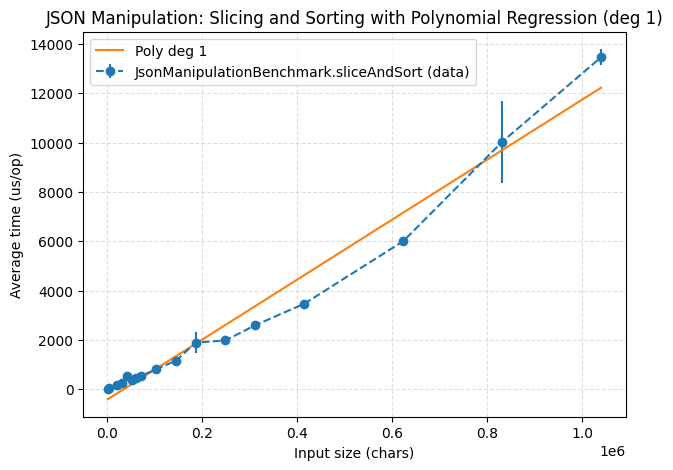

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


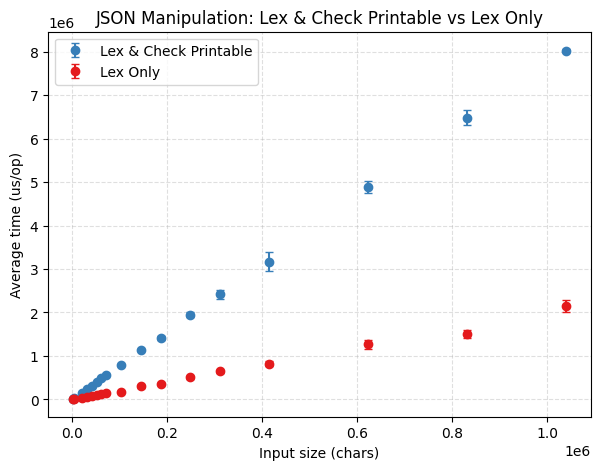

PosixPath('plots/JSON Manipulation: Lex & Check Printable vs Lex Only.eps')

In [67]:
latest_folder = Path("./latest")
json_manipulation_file = None
for entry in os.listdir(latest_folder):
    if 'json_manipulation' in entry.lower():
        json_manipulation_file = latest_folder / entry
        break

# If found, parse and plot
assert json_manipulation_file is not None, "No json_manipulation file found in latest folder."
with open(json_manipulation_file, "r") as f:
  raw3 = f.read()
  data3 = parse_jmh_table(raw3)

benchRecombineWithoutWrapper = "JsonManipulationBenchmark.checkPredicateAndRecombineWithoutWrapper"
benchLex = "JsonManipulationBenchmark.lex"
benchLexAndCheckPrintable = "JsonManipulationBenchmark.lexAndCheckPrintable"
benchRecombineSlices = "JsonManipulationBenchmark.recombineSlices"
benchSliceAndSort = "JsonManipulationBenchmark.sliceAndSort"

pretty_labels = {
      benchRecombineWithoutWrapper: "Recombine Without Wrapper",
      benchLex: "Lex Only",
      benchLexAndCheckPrintable: "Lex & Check Printable",
      benchRecombineSlices: "Recombine Slices",
      benchSliceAndSort: "Slice and Sort"
}

plot2((benchRecombineWithoutWrapper, data3[benchRecombineWithoutWrapper]),
      (benchRecombineSlices, data3[benchRecombineSlices]),
      title="JSON Manipulation: Recombining With vs Without Wrapper",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot_with_regression((benchLex, data3[benchLex]),
                     degree=1,
                     title="JSON Manipulation: Lexing with Polynomial Regression (deg 1)",
                     output_folder="plots",
                     fmt="eps")

plot_with_regression((benchSliceAndSort, data3[benchSliceAndSort]),
                     degree=1,
                     title="JSON Manipulation: Slicing and Sorting with Polynomial Regression (deg 1)",
                     output_folder="plots",
                     fmt="eps")

plot2((benchLexAndCheckPrintable, data3[benchLexAndCheckPrintable]),
      (benchLex, data3[benchLex]),
      title="JSON Manipulation: Lex & Check Printable vs Lex Only",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")




# Regex Benchmark Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


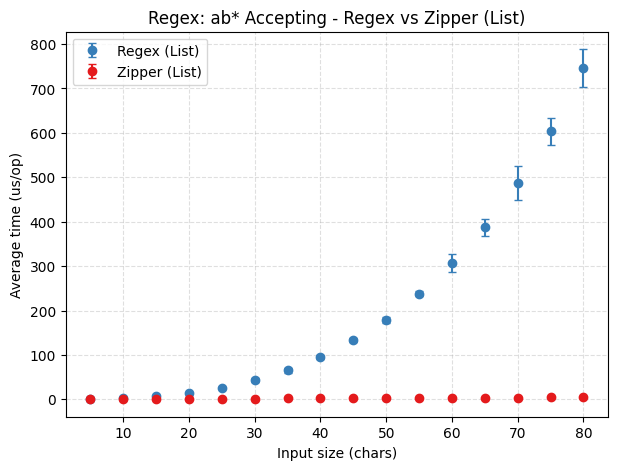

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


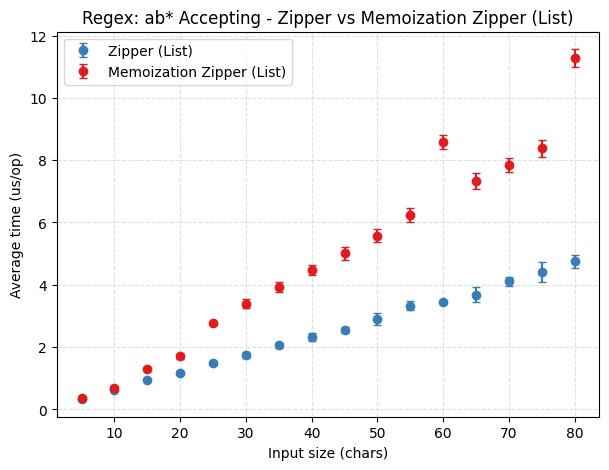

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


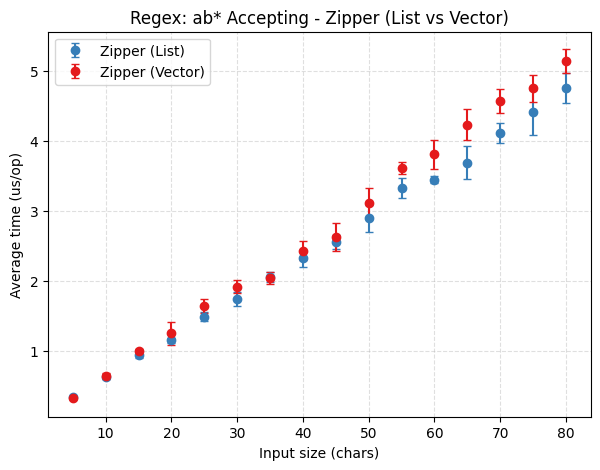

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


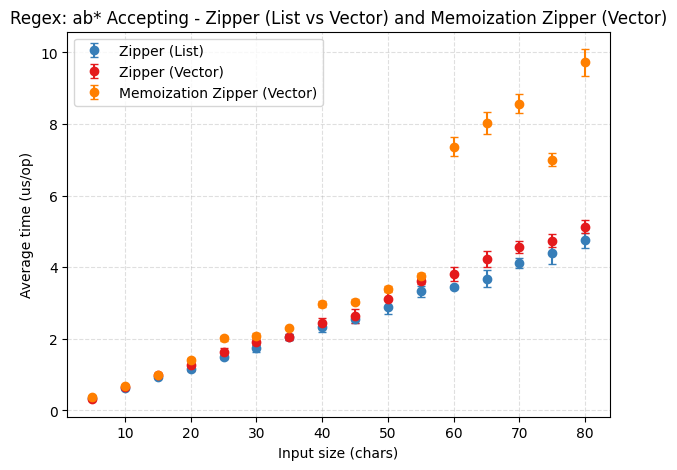

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


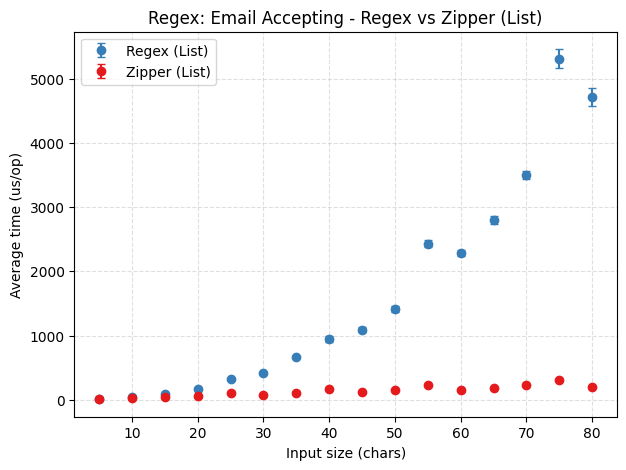

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


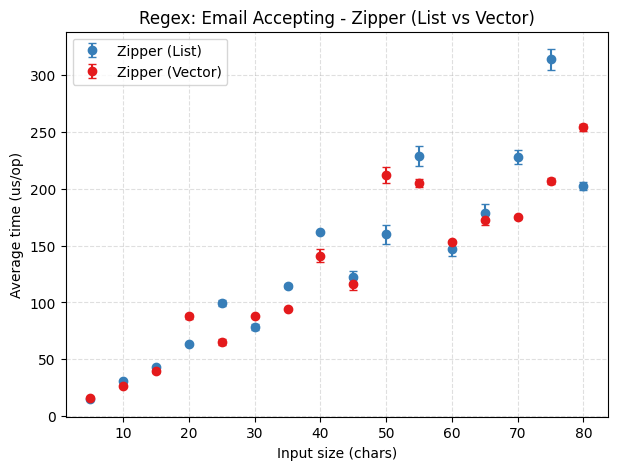

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


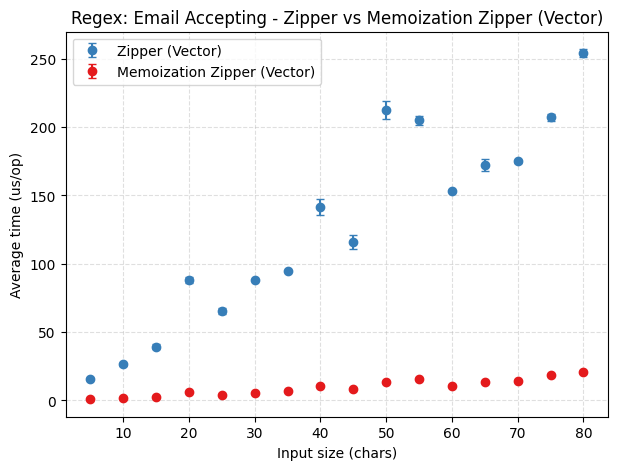

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


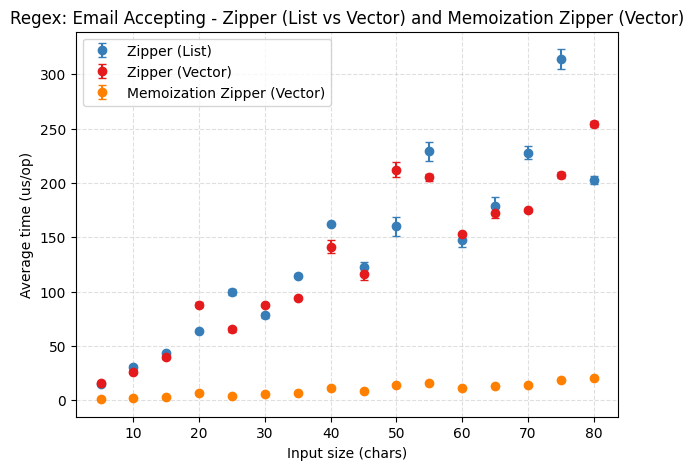

PosixPath('plots/Regex: Email Accepting - Zipper (List vs Vector) and Memoization Zipper (Vector).eps')

In [66]:
latest_folder = Path("./latest")
regex_benchmark_file = None
for entry in os.listdir(latest_folder):
    if 'regex_benchmark' in entry.lower():
        regex_benchmark_file = latest_folder / entry
        break

assert regex_benchmark_file is not None, "Could not find regex benchmark file in 'latest' folder."
with open(regex_benchmark_file, "r") as f:
    raw4 = f.read()
data4 = parse_jmh_table(raw4)

abStarAccepting_Regex_list = "RegexBenchmark.abStarAccepting_Regex_list"
abStarAccepting_ZipperMem_list = "RegexBenchmark.abStarAccepting_ZipperMem_list"
abStarAccepting_ZipperMem_vector = "RegexBenchmark.abStarAccepting_ZipperMem_vector"
abStarAccepting_Zipper_list = "RegexBenchmark.abStarAccepting_Zipper_list"
abStarAccepting_Zipper_vector = "RegexBenchmark.abStarAccepting_Zipper_vector"
emailAccepting_RegexMem_list = "RegexBenchmark.emailAccepting_RegexMem_list"
emailAccepting_Regex_list = "RegexBenchmark.emailAccepting_Regex_list"
emailAccepting_ZipperMem_vector = "RegexBenchmark.emailAccepting_ZipperMem_vector"
emailAccepting_Zipper_list = "RegexBenchmark.emailAccepting_Zipper_list"
emailAccepting_Zipper_vector = "RegexBenchmark.emailAccepting_Zipper_vector"

pretty_labels = {
      abStarAccepting_Regex_list: "Regex (List)",
      abStarAccepting_Zipper_list: "Zipper (List)",
      abStarAccepting_ZipperMem_list: "Memoization Zipper (List)",
      abStarAccepting_Zipper_vector: "Zipper (Vector)",
      abStarAccepting_ZipperMem_vector: "Memoization Zipper (Vector)",
      emailAccepting_Regex_list: "Regex (List)",
      emailAccepting_RegexMem_list: "Memoization Regex (List)",
      emailAccepting_Zipper_list: "Zipper (List)",
      emailAccepting_Zipper_vector: "Zipper (Vector)",
      emailAccepting_ZipperMem_vector: "Memoization Zipper (Vector)",
}

plot2((abStarAccepting_Regex_list, data4[abStarAccepting_Regex_list]),
      (abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      title="Regex: ab* Accepting - Regex vs Zipper (List)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      (abStarAccepting_ZipperMem_list, data4[abStarAccepting_ZipperMem_list]),
      title="Regex: ab* Accepting - Zipper vs Memoization Zipper (List)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      (abStarAccepting_Zipper_vector, data4[abStarAccepting_Zipper_vector]),
      title="Regex: ab* Accepting - Zipper (List vs Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot3((abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      (abStarAccepting_Zipper_vector, data4[abStarAccepting_Zipper_vector]),
      (abStarAccepting_ZipperMem_vector, data4[abStarAccepting_ZipperMem_vector]),
      title="Regex: ab* Accepting - Zipper (List vs Vector) and Memoization Zipper (Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((emailAccepting_Regex_list, data4[emailAccepting_Regex_list]),
      (emailAccepting_Zipper_list, data4[emailAccepting_Zipper_list]),
      title="Regex: Email Accepting - Regex vs Zipper (List)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((emailAccepting_Zipper_list, data4[emailAccepting_Zipper_list]),
      (emailAccepting_Zipper_vector, data4[emailAccepting_Zipper_vector]),
      title="Regex: Email Accepting - Zipper (List vs Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((emailAccepting_Zipper_vector, data4[emailAccepting_Zipper_vector]),
      (emailAccepting_ZipperMem_vector, data4[emailAccepting_ZipperMem_vector]),
      title="Regex: Email Accepting - Zipper vs Memoization Zipper (Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot3((emailAccepting_Zipper_list, data4[emailAccepting_Zipper_list]),
      (emailAccepting_Zipper_vector, data4[emailAccepting_Zipper_vector]),
      (emailAccepting_ZipperMem_vector, data4[emailAccepting_ZipperMem_vector]),
      title="Regex: Email Accepting - Zipper (List vs Vector) and Memoization Zipper (Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")
